## Probability of Detection (Pdet) generation and comparison

This notebook is a full guide on how to use the `gwsnr` package to generate the Pdet for a given Gravitational Wave (GW) signal parameters.

## Contents of this notebook

Calculation by considering $P_{\rm det}$ as,
- Boolean (detected if 1, not detected if 0)
  - with $\rho_{\rm obs}$ as non-central $\chi$ distribution
  - with $\rho_{\rm obs}$ as Gaussian distribution
  - with $\rho_{\rm opt}$ as Fixed SNR.
- Probabilistic (between 0 and 1)
  - with $\rho_{\rm obs}$ as non-central $\chi$ distribution
  - with $\rho_{\rm obs}$ as Gaussian distribution

For snr generation, in this example notebook, I will use the default snr_method, i.e. 'interpolation_aligned_spins'. Please refer to the snr_generation.ipynb for more details on snr generation methods.

'pdet_kwargs' can be initialized while creating the GWSNR class object or the pdet related parameters can be passed while calling the pdet calculation method.

Note: For more details on Pdet calculation methods, please refer to the [gwsnr documentation](https://gwsnr.hemantaph.com).

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import gwsnr
np.random.seed(42)

gwsnr = gwsnr.GWSNR(
    npool=4,
    snr_method='interpolation_aligned_spins', 
    gwsnr_verbose=False,
    waveform_approximant='IMRPhenomD',
    # pdet_kwargs=dict(snr_th=10.0, snr_th_net=10.0, pdet_type='boolean', distribution_type='noncentral_chi2') # 'pdet_kwargs' can be initialized while creating the GWSNR class object or the pdet related settings can be passed while calling the pdet calculation method.
)

mass_1 = np.array([2,50.,100.,])
ratio = 0.9
dl = 500
# pdet with default settings 
pdet = gwsnr.pdet(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl)

print("Network Pdet (boolean, non-central chi2) : ", pdet['pdet_net'])


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_3.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_3.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_3.pickle


Network Pdet (boolean, non-central chi2) :  [0 1 1]


In [ ]:
# get `ler` package generated GW parameters for BBH
!wget https://github.com/hemantaph/gwsnr/blob/main/tests/integration/bbh_gw_params.json

--2025-10-27 17:39:22--  https://github.com/hemantaph/gwsnr/blob/main/tests/integration/bbh_gw_params.json
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘bbh_gw_params.json’

bbh_gw_params.json      [ <=>                ] 181.27K  1.03MB/s    in 0.2s    

2025-10-27 17:39:23 (1.03 MB/s) - ‘bbh_gw_params.json’ saved [185616]



In [ ]:
from gwsnr.utils import get_param_from_json
param_dict = get_param_from_json('bbh_gw_params.json')

## Boolean Pdet calculation

### Non-Central $\chi$ distribution

In [19]:
pdet_chi2 = gwsnr.pdet(
    gw_param_dict=param_dict,
    snr_th_net=10.0,
    pdet_type='boolean',
    distribution_type='noncentral_chi2',
    include_observed_snr=True, # to include observed SNR values in the output dictionary
)
# print the first 5 pdet values
print(pdet_chi2['pdet_net'][:5])
print(pdet_chi2['observed_snr_net'][:5])

# find and print detectable fraction
detectable_fraction = np.mean(pdet_chi2['pdet_net'])
print("Detectable fraction of the population : ", detectable_fraction)

[0 1 1 0 0]
[ 4.96745777 15.29014732 13.73626925  2.67832879  2.57440876]
Detectable fraction of the population :  0.33


### Gaussian distribution

In [20]:
pdet_gauss = gwsnr.pdet(
    gw_param_dict=param_dict,
    snr_th_net=10.0,
    pdet_type='boolean',
    distribution_type='gaussian',
    include_observed_snr=True
)
# print the first 5 pdet values
print(pdet_gauss['pdet_net'][:5])
print(pdet_gauss['observed_snr_net'][:5])

# find and print detectable fraction
detectable_fraction = np.mean(pdet_gauss['pdet_net'])
print("Detectable fraction of the population : ", detectable_fraction)

[0 1 1 0 0]
[ 4.87782373 15.50141248 14.35847191  3.64935961  2.98302797]
Detectable fraction of the population :  0.34


### Fixed SNR

In [21]:
pdet_optsnr = gwsnr.pdet(
    gw_param_dict=param_dict,
    snr_th_net=10.0,
    pdet_type='boolean',
    distribution_type='fixed_snr',
    include_observed_snr=True,  # here observed_snr_net will be same as optimal SNR
)
# print the first 5 pdet values
print(pdet_optsnr['pdet_net'][:5])
print(pdet_optsnr['observed_snr_net'][:5])

# find and print detectable fraction
detectable_fraction = np.mean(pdet_optsnr['pdet_net'])
print("Detectable fraction of the population : ", detectable_fraction)

[0 1 1 0 0]
[ 4.21494246 14.32793862 14.17745035  4.94619156  2.58334002]
Detectable fraction of the population :  0.32


### Visulalization and Comparison Observed SNR distributions wrt to Optimal SNR

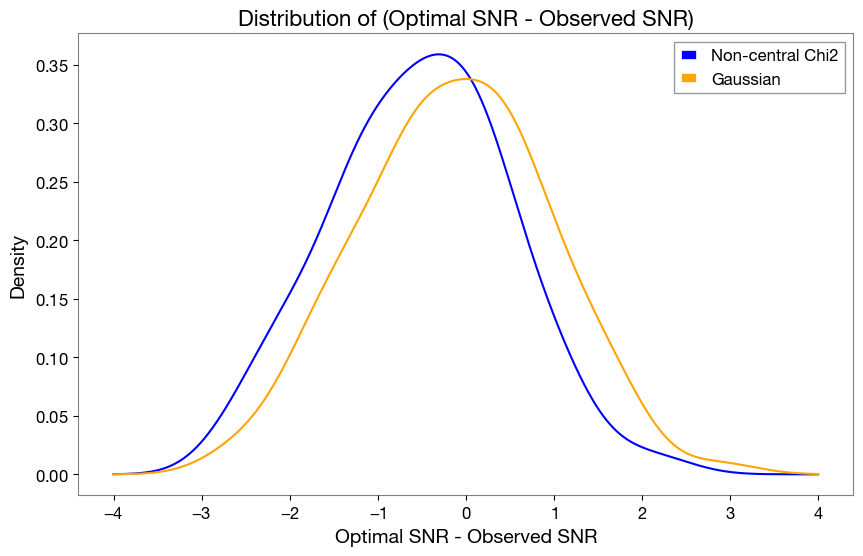

In [25]:
snr_opt = pdet_optsnr['observed_snr_net']
snr_obs_chi2 = pdet_chi2['observed_snr_net']
snr_obs_gauss = pdet_gauss['observed_snr_net']

dist1 = snr_opt - snr_obs_chi2
dist2 = snr_opt - snr_obs_gauss

# create kde plots to compare the two distributions
from scipy.stats import gaussian_kde

kde1 = gaussian_kde(dist1)
kde2 = gaussian_kde(dist2)
x = np.linspace(-4, 4, 1000)

plt.figure(figsize=(10,6))
# plt.hist(dist1, bins=30, alpha=0.5, label='Non-central Chi2', color='blue', density=True, histtype='step')
# plt.hist(dist2, bins=30, alpha=0.5, label='Gaussian', color='orange', density=True, histtype='step')
plt.plot(x, kde1(x), label='Non-central Chi2', color='blue')
plt.plot(x, kde2(x), label='Gaussian', color='orange')
plt.title('Distribution of (Optimal SNR - Observed SNR)', fontsize=16)
plt.xlabel('Optimal SNR - Observed SNR', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

## Probabilistic Pdet calculation


### Non-Central $\chi$ distribution

In [27]:
pdet_chi2 = gwsnr.pdet(
    gw_param_dict=param_dict,
    snr_th_net=10.0,
    pdet_type='probability_distribution',
    distribution_type='noncentral_chi2',
    include_optimal_snr=True, # to include optimal SNR values in the output dictionary
)
# print the first 5 pdet values
print(pdet_chi2['pdet_net'][:5])
print(pdet_chi2['optimal_snr_net'][:5])

# find and print detectable fraction
detectable_fraction = np.mean(pdet_chi2['pdet_net'])
print("Detectable fraction of the population : ", detectable_fraction)

[3.13236730e-08 9.99997133e-01 9.99994244e-01 1.26963490e-06
 1.70041758e-12]
[ 4.21494246 14.32793862 14.17745035  4.94619156  2.58334002]
Detectable fraction of the population :  0.3272490373160273


### Gaussian distribution

In [28]:
pdet_gauss = gwsnr.pdet(
    gw_param_dict=param_dict,
    snr_th_net=10.0,
    pdet_type='probability_distribution',
    distribution_type='gaussian',
    include_optimal_snr=True
)
# print the first 5 pdet values
print(pdet_gauss['pdet_net'][:5])
print(pdet_gauss['optimal_snr_net'][:5])

# find and print detectable fraction
detectable_fraction = np.mean(pdet_gauss['pdet_net'])
print("Detectable fraction of the population : ", detectable_fraction)

[3.62437580e-09 9.99992474e-01 9.99985260e-01 2.16542995e-07
 6.00630656e-14]
[ 4.21494246 14.32793862 14.17745035  4.94619156  2.58334002]
Detectable fraction of the population :  0.32040024945890544


0.9997810824868587
0.9993681083703562


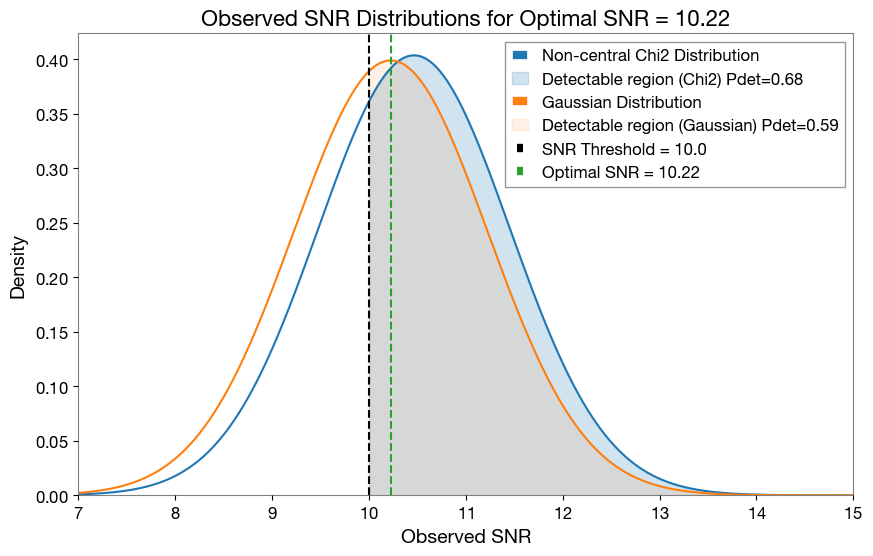

In [97]:
### Visulalization Pdet based on Probability distribution of Observed SNR wrt to Optimal SNR
from scipy.stats import norm, ncx2
min_snr = 7
max_snr = 15
x_values = np.linspace(min_snr, max_snr, 1000)
# pdet_gauss['pdet_net'] between 0.2 and 0.5
selected_indices = np.where((pdet_gauss['pdet_net'] >= 0.5) & (pdet_gauss['pdet_net'] <= 0.9))[0]
selected_index = selected_indices[0]

# Non-central Chi2 distribution case
size = 1000
nc_param = pdet_chi2['optimal_snr_net'][selected_index]**2
df = 2 * len(gwsnr.detector_list)
pdf_dist1 = ncx2.pdf(x_values**2, df=df, nc=nc_param)
print(np.trapz(pdf_dist1, x_values**2))
# normalize the pdf; or you might need to take care of Jacobian while plotting
# pdf_dist1 /= np.trapz(pdf_dist1, x_values)

# Gaussian distribution case
size = 1000
mu = pdet_gauss['optimal_snr_net'][selected_index]
sigma = 1.0  # standard deviation
pdf_dist2 = norm(loc=mu, scale=sigma)
pdf_dist2 = pdf_dist2.pdf(x_values)
print(np.trapz(pdf_dist2, x_values))
# pdf_dist2 /= np.trapz(pdf_dist2, x_values)


plt.figure(figsize=(10,6))

plt.plot(x_values, pdf_dist1 * 2 * x_values, label='Non-central Chi2 Distribution', color='C0')
plt.fill_between(x_values, 0, pdf_dist1 * 2 * x_values, where=(x_values >= 10.0), alpha=0.2, color='C0', label=f'Detectable region (Chi2) Pdet={pdet_chi2["pdet_net"][selected_index]:.2f}')

plt.plot(x_values, pdf_dist2, label='Gaussian Distribution', color='C1')
plt.fill_between(x_values, 0, pdf_dist2, where=(x_values >= 10.0), alpha=0.1, color='C1', label=f'Detectable region (Gaussian) Pdet={pdet_gauss["pdet_net"][selected_index]:.2f}')


plt.title('Observed SNR Distributions for Optimal SNR = {:.2f}'.format(pdet_gauss['optimal_snr_net'][selected_index]), fontsize=16)
# vertical line for SNR threshold
plt.axvline(x=10.0, color='k', linestyle='--', label='SNR Threshold = 10.0')
plt.axvline(x=pdet_chi2['optimal_snr_net'][selected_index], color='C2', linestyle='--', label=f'Optimal SNR = {pdet_chi2["optimal_snr_net"][selected_index]:.2f}')

plt.legend(fontsize=12, loc='upper right')
plt.xlim(7, 15)
plt.ylim(0, None)
plt.xlabel('Observed SNR', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid()
plt.show()